# ELEN 6893 Final Project - NYC Taxi Fare Prediction
## Di Wu (dw2834) / Shuhao Qiao (sq2205) / Yunfei Wang (yw3157) - 12/13/2018

## Spark Initialization

In [1]:
# Tell jupyter where pyspark is
import findspark
findspark.init()

In [2]:
# Import relative packages
from pyspark.sql import SparkSession

In [3]:
# Build a SparkSession
spark = SparkSession\
    .builder\
    .appName("taxiproject")\
    .getOrCreate()

## Import Data

In [4]:
# Initialization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt, pi
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer, IndexToString, StringIndexer, VectorIndexer
import datetime as dt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import shap

In [5]:
# Read train data (0.1%) as dataframes
train_df = pd.read_csv('./FinalProject/train.csv', nrows = 50000)
train_df[0:5]
#train_df.to_csv('./FinalProject/1.csv', index=0)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
# Read test data as dataframes
test_df = pd.read_csv('./FinalProject/test.csv')
test_df[0:3]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1


In [7]:
# Output naive submission file
test_df['fare_amount'] = train_df['fare_amount'].mean()
test_df.to_csv('./FinalProject/submission_naive.csv', index=0, columns=['key', 'fare_amount'])

▶▶ Kaggle submission score: 9.40948 ( Rank 1419 / 1488 )

## Function Definitions

In [8]:
# Transfer csv file to libsvm file for convenience
import csv
def csv_to_libsvm(file1, file2):
    csv_csv = csv.reader(open(file1,'r') )
    csv_list = []
    for i in csv_csv:
        csv_list.append(i)
    csv_list = csv_list[1:len(csv_list)]
    fl = open(file2,'w')
    length = len(csv_list[0])
    for i in csv_list:
        fl.write(str(i[0]))
        for j in range(1,length):
            fl.write(' '+str(j)+':'+str(i[j]))
        fl.write('\n')

In [9]:
# Add a features 'distance' to dataframe
def add_distance(df):
    distance = []
    lat1_r = df['pickup_latitude'].apply(lambda x: radians(x))
    lat2_r = df['dropoff_latitude'].apply(lambda x: radians(x))
    lon1_r = df['pickup_longitude'].apply(lambda x: radians(x))
    lon2_r = df['dropoff_longitude'].apply(lambda x: radians(x))
    
    dlon = (lon2_r - lon1_r).abs()
    dlat = (lat2_r - lat1_r).abs()
    
    dlat = dlat.apply(lambda x: sin(x/2) ** 2)
    lat1_r = lat1_r.apply(lambda x: cos(x))
    lat2_r = lat2_r.apply(lambda x: cos(x))
    dlon = dlon.apply(lambda x: sin(x/2) ** 2)
    a = dlat + lat1_r * lat2_r * dlon
    c = a.apply(lambda x: 2 * asin(sqrt(x)))
    r = 6371
    df['distance'] = c * r * 1000

In [10]:
def compute_distance(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):

    lat1_r, lon1_r, lat2_r, lon2_r = map(np.radians,[pickup_lat, pickup_lon, dropoff_lat, dropoff_lon])
    dlon = (lon2_r - lon1_r).abs()
    dlat = (lat2_r - lat1_r).abs()
    
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    r = 6371
    return 2 * r * np.arcsin(np.sqrt(a))

In [11]:
# Add two features 'hour' and 'weekday' to dataframe
def add_datetime_info(dataset):
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday

In [12]:
# Add all time features to dataframe
def add_datetime_info(dataset):
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year

In [13]:
# Add the minimum distance to three airports to dataframe
def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk = (40.639722, -73.778889)
    ewr = (40.6925, -74.168611)
    lga = (40.77725, -73.872611)
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = compute_distance(pickup_lat, pickup_lon, jfk[0], jfk[1]) 
    dropoff_jfk = compute_distance(jfk[0], jfk[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = compute_distance(pickup_lat, pickup_lon, ewr[0], ewr[1])
    dropoff_ewr = compute_distance(ewr[0], ewr[1], dropoff_lat, dropoff_lon) 
    pickup_lga = compute_distance(pickup_lat, pickup_lon, lga[0], lga[1]) 
    dropoff_lga = compute_distance(lga[0], lga[1], dropoff_lat, dropoff_lon)
    
    pickup_jfk = pickup_jfk.tolist()
    dropoff_jfk = dropoff_jfk.tolist()
    pickup_ewr = pickup_ewr.tolist()
    dropoff_ewr = dropoff_ewr.tolist()
    pickup_lga = pickup_lga.tolist()
    dropoff_lga = dropoff_lga.tolist()
    
    min_jfk = []
    min_ewr = []
    min_lga = []
    
    for i in range(len(pickup_jfk)):
        min_jfk.append(min(pickup_jfk[i], dropoff_jfk[i]))
        min_ewr.append(min(pickup_ewr[i], dropoff_ewr[i]))
        min_lga.append(min(pickup_lga[i], dropoff_lga[i]))
        
    dataset['jfk_dist'] = min_jfk
    dataset['ewr_dist'] = min_ewr
    dataset['lga_dist'] = min_lga

## Data Overview

Note that part of codes in this cell is from Albert van Breemen's Kernel [NYC Taxi Fare - Data Exploration](https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration).

In [14]:
# Train data overview
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734371,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


Obviously there are some strange data which should be removed.

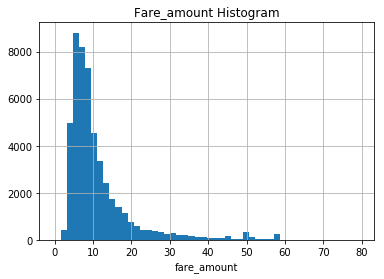

In [15]:
# Plot histogram of fare_amount
train_df[(train_df.fare_amount > 0) & (train_df.fare_amount < 80)].fare_amount.hist(bins = 50)
plt.xlabel('fare_amount')
plt.title('Fare_amount Histogram');

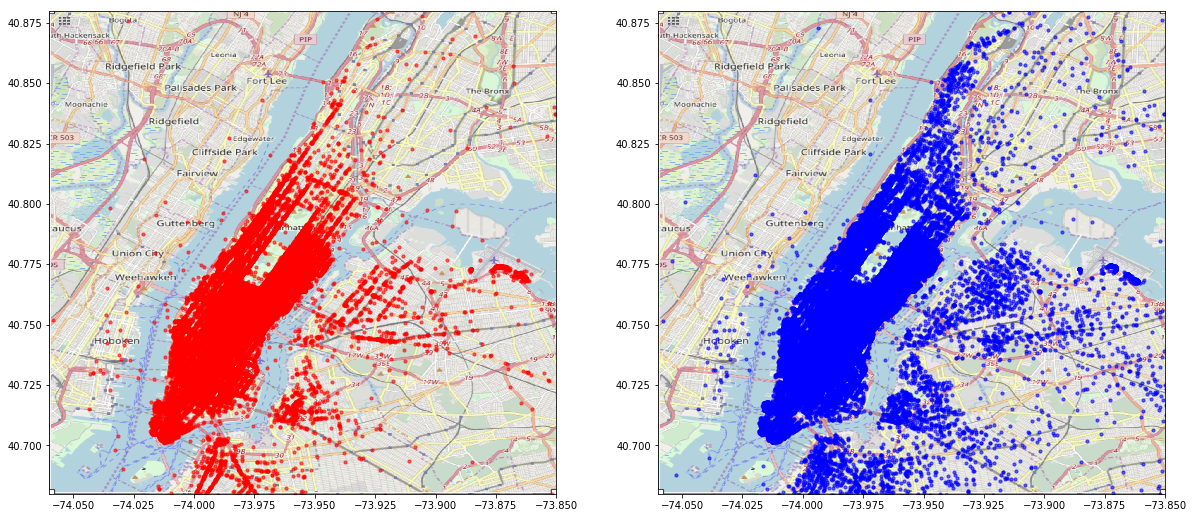

In [16]:
# Plot the pickup and dropoff locations on a nyc map
BB_zoom = (-74.06, -73.85, 40.68, 40.88)
nyc_map_zoom = plt.imread('nycmap.png')
def plot_on_map(df, BB, nyc_map, s=0.6, alpha=0.1):
    fig, axs = plt.subplots(1, 2, figsize=(20,20))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    #axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    #axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
plot_on_map(train_df, BB_zoom, nyc_map_zoom, s=10, alpha=0.6)

/home/dw2834/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log1p
  del sys.path[0]


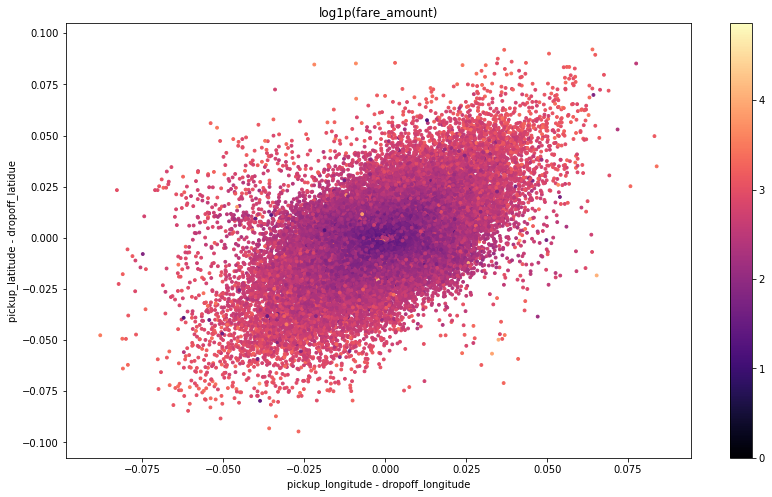

In [17]:
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

train_df['delta_lon'] = train_df.pickup_longitude - train_df.dropoff_longitude
train_df['delta_lat'] = train_df.pickup_latitude - train_df.dropoff_latitude

# Select trips in Manhattan
BB_manhattan = (-74.025, -73.925, 40.7, 40.8)
idx_manhattan = select_within_boundingbox(train_df, BB_manhattan)

plt.figure(figsize=(14,8))
plt.scatter(train_df[idx_manhattan].delta_lon, train_df[idx_manhattan].delta_lat, s=8, alpha=1, 
            c=np.log1p(train_df[idx_manhattan].fare_amount), cmap='magma')
plt.colorbar()
plt.xlabel('pickup_longitude - dropoff_longitude')
plt.ylabel('pickup_latitude - dropoff_latidue')
plt.title('log1p(fare_amount)');
plt.savefig('filename.png', dpi = 300) 

## Data Preprocessing

In [18]:
# Add two features 'diff_lon' and 'diff_lat' to train and test dataframe
def add_diff_lon_lat(df):
    df['diff_lon'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['diff_lat'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_diff_lon_lat(train_df)
add_diff_lon_lat(test_df)

In [19]:
# Remove the data with null value
print('The size of data before processing: ', len(train_df))
print("Removing null data...")
train_df = train_df[(train_df.pickup_longitude > -180) & (train_df.pickup_longitude != 0) & (train_df.pickup_latitude != 0)]
print('The size of data after processing: ', len(train_df))

# Remove the data with strange distance value
print('\nThe size of data before processing: ', len(train_df))
print("Removing strange data...")
train_df = train_df[(train_df.diff_lon < 5.0) & (train_df.diff_lat < 5.0)]
print('The size of data after processing: ', len(train_df))

# Remove the data with strange latitude and longitude
print('\nThe size of data before processing: ', len(train_df))
print("Removing strange data...")
train_df = train_df[(train_df.pickup_longitude < -73) & (train_df.pickup_longitude > -75)]
train_df = train_df[(train_df.pickup_latitude < 42) & (train_df.pickup_latitude > 40)]
train_df = train_df[(train_df.dropoff_longitude < -73) & (train_df.dropoff_longitude > -75)]
train_df = train_df[(train_df.dropoff_latitude < 42) & (train_df.dropoff_latitude > 40)]
print('The size of data after processing: ', len(train_df))

The size of data before processing:  50000
Removing null data...
The size of data after processing:  49043

The size of data before processing:  49043
Removing strange data...
The size of data after processing:  48992

The size of data before processing:  48992
Removing strange data...
The size of data after processing:  48952


In [20]:
# Add 'distance' to both train and test dataframe
add_distance(train_df)
add_distance(test_df)

In [21]:
train_df[0:3]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,delta_lon,delta_lat,diff_lon,diff_lat,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,-0.002701,0.009041,0.002701,0.009041,1030.763935
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,-0.036780,-0.070701,0.036780,0.070701,8450.133596
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,0.008504,0.010708,1389.525226


In [22]:
test_df[0:3]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,diff_lon,diff_lat,distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,11.364171,0.008110,0.019970,2323.259660
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,11.364171,0.012024,0.019817,2425.352985
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,11.364171,0.002870,0.005121,618.627871


## Regression on Distance

In [23]:
# Predictor: distance
train_df.to_csv('./FinalProject/train_distance.csv', index=0, columns=['fare_amount', 'distance'])
test_df.to_csv('./FinalProject/test_distance_csv.csv', index=0, columns=['fare_amount', 'distance'])
print("csv files generated")

# Transfer csv files to libsvm files
csv_to_libsvm('./FinalProject/train_distance.csv','./FinalProject/train_distance.txt')
csv_to_libsvm('./FinalProject/test_distance_csv.csv','./FinalProject/test_distance_txt.txt')
print('libsvm files generated')

# Load spark dataframe
train_distance = spark.read.format("libsvm").load("./FinalProject/train_distance.txt")
test_distance = spark.read.format("libsvm").load("./FinalProject/test_distance_txt.txt")
print('Libsvm file loaded to spark')

csv files generated
libsvm files generated
Libsvm file loaded to spark


In [24]:
# Linear Regression
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train_distance)
prediction = test_df.distance * lrModel.coefficients[0] + lrModel.intercept

# Output distance_linear submission file
test_df['fare_amount'] = prediction
test_df.to_csv('./FinalProject/submission_distance_linear.csv', index=0, columns=['key', 'fare_amount'])

▶▶ Kaggle submission score: 5.79968 ( Rank 1331 / 1488 )

In [25]:
# Decision Tree Regression
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")
featureIndexerTrain = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(train_distance)
featureIndexerTest = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(test_distance)
dtChain = Pipeline(stages=[featureIndexerTrain, dt])
dtModel = dtChain.fit(train_distance)
prediction = dtModel.transform(test_distance)

# Output distance_decisiontree submission file
col = prediction.select('prediction').collect()
pre = []
for i in col:
    pre.append(i[0])
test_df['fare_amount'] = pre
test_df.to_csv('./FinalProject/submission_distance_decisiontree.csv', index=0, columns=['key', 'fare_amount'])

▶▶ Kaggle submission score: 4.55898 ( Rank 1105 / 1488 )

In [26]:
# Random Forest Regression
# Create a random forest regression model, chain indexer and tree and fit the model
rf = RandomForestRegressor(featuresCol="indexedFeatures2")
featureIndexerTrain = VectorIndexer(inputCol="features", outputCol="indexedFeatures2", maxCategories=4).fit(train_distance)
featureIndexerTest = VectorIndexer(inputCol="features", outputCol="indexedFeatures2", maxCategories=4).fit(test_distance)
rfChain = Pipeline(stages=[featureIndexerTrain, rf])
rfModel = rfChain.fit(train_distance)
prediction = rfModel.transform(test_distance)

# Output distance_randomforest submission file
col2 = prediction.select('prediction').collect()
pre2 = []
for i in col2:
    pre2.append(i[0])
test_df['fare_amount'] = pre2
test_df.to_csv('./FinalProject/submission_distance_randomforest.csv', index=0, columns=['key', 'fare_amount'])

▶▶ Kaggle submission score: 4.50127 ( Rank 1095 / 1488 )

## Regression on Distance + Position

In [27]:
# Predictor: distance + four specific position
train_df.to_csv('./FinalProject/train_dispos.csv', index=0, columns=['fare_amount', 'distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
test_df.to_csv('./FinalProject/test_dispos_csv.csv', index=0, columns=['fare_amount', 'distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
print("csv files generated")

# Transfer csv files to libsvm files
csv_to_libsvm('./FinalProject/train_dispos.csv','./FinalProject/train_dispos.txt')
csv_to_libsvm('./FinalProject/test_dispos_csv.csv','./FinalProject/test_dispos_txt.txt')
print('libsvm files generated')

# Load spark dataframe
train_dispos = spark.read.format("libsvm").load("./FinalProject/train_dispos.txt")
test_dispos = spark.read.format("libsvm").load("./FinalProject/test_dispos_txt.txt")
print('Libsvm file loaded to spark')

csv files generated
libsvm files generated
Libsvm file loaded to spark


In [28]:
# Decision Tree Regression
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")
featureIndexerTrain = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5).fit(train_dispos)
featureIndexerTest = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5).fit(test_dispos)
dtChain = Pipeline(stages=[featureIndexerTrain, dt])
dtModel = dtChain.fit(train_dispos)
prediction = dtModel.transform(test_dispos)

# Output distance_decisiontree submission file
col = prediction.select('prediction').collect()
pre = []
for i in col:
    pre.append(i[0])
test_df['fare_amount'] = pre
test_df.to_csv('./FinalProject/submission_dispos_decisiontree.csv', index=0, columns=['key', 'fare_amount'])

▶▶ Kaggle submission score: 4.28111 ( Rank 1054 / 1488 )

In [29]:
# Random Forest Regression
# Create a random forest regression model, chain indexer and tree and fit the model
rf = RandomForestRegressor(featuresCol="indexedFeatures2")
featureIndexerTrain = VectorIndexer(inputCol="features", outputCol="indexedFeatures2", maxCategories=5).fit(train_dispos)
featureIndexerTest = VectorIndexer(inputCol="features", outputCol="indexedFeatures2", maxCategories=5).fit(test_dispos)
rfChain = Pipeline(stages=[featureIndexerTrain, rf])
rfModel = rfChain.fit(train_dispos)
prediction = rfModel.transform(test_dispos)

# Output distance_randomforest submission file
col2 = prediction.select('prediction').collect()
pre2 = []
for i in col2:
    pre2.append(i[0])
test_df['fare_amount'] = pre2
test_df.to_csv('./FinalProject/submission_dispos_randomforest.csv', index=0, columns=['key', 'fare_amount'])

▶▶ Kaggle submission score: 4.42862

## Regression on All Predictors (Distance + Position + Time + Passenger)

In [30]:
# Predictor: distance + four specific position + start hour
add_datetime_info(train_df)
add_datetime_info(test_df)
print("time info added")

train_df.to_csv('./FinalProject/train_dispostimepas.csv', index=0, columns=['fare_amount', 'distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour', 'weekday'])
test_df.to_csv('./FinalProject/test_dispostimepas_csv.csv', index=0, columns=['fare_amount', 'distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour', 'weekday'])
print("csv files generated")

# Transfer csv files to libsvm files
csv_to_libsvm('./FinalProject/train_dispostimepas.csv','./FinalProject/train_dispostimepas.txt')
csv_to_libsvm('./FinalProject/test_dispostimepas_csv.csv','./FinalProject/test_dispostimepas_txt.txt')
print('libsvm files generated')

# Load spark dataframe
train_dispostimepas = spark.read.format("libsvm").load("./FinalProject/train_dispostimepas.txt")
test_dispostimepas = spark.read.format("libsvm").load("./FinalProject/test_dispostimepas_txt.txt")
print('Libsvm file loaded to spark')

time info added
csv files generated
libsvm files generated
Libsvm file loaded to spark


In [31]:
# Decision Tree Regression
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")
featureIndexerTrain = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=8).fit(train_dispostimepas)
featureIndexerTest = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=8).fit(test_dispostimepas)
dtChain = Pipeline(stages=[featureIndexerTrain, dt])
dtModel = dtChain.fit(train_dispostimepas)
prediction = dtModel.transform(test_dispostimepas)

# Output distance_decisiontree submission file
col = prediction.select('prediction').collect()
pre = []
for i in col:
    pre.append(i[0])
test_df['fare_amount'] = pre
test_df.to_csv('./FinalProject/submission_dispostimepas_decisiontree.csv', index=0, columns=['key', 'fare_amount'])

▶▶ Kaggle submission score: 4.25675 ( Rank 1046 / 1488 )

## Predict using LightGBM

In [32]:
import lightgbm as lgbm
add_datetime_info(train_df)
add_datetime_info(test_df)

In [33]:
train_x_lgbm = train_df[['distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour', 'weekday']]
train_y_lgbm = train_df['fare_amount']
test_x_lgbm = test_df[['distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour', 'weekday']]
test_key = test_df['key']

In [34]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }

In [35]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_x_lgbm, train_y_lgbm, random_state=123, test_size=0.10)

train_set = lgbm.Dataset(x_train, y_train, silent=False)
valid_set = lgbm.Dataset(x_test, y_test, silent=False)
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)

/home/dw2834/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 4.10626
Early stopping, best iteration is:
[245]	valid_0's rmse: 4.08537


In [36]:
prediction = model.predict(test_x_lgbm, num_iteration = model.best_iteration)      
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})

submission.to_csv('./FinalProject/submission_dispostimepas_lgbm.csv',index=False)

▶▶ Kaggle submission score: 3.56563 ( Rank 721 / 1488 )

## Final model: Using LightGBM and all predictors

In [37]:
add_datetime_info(train_df)
add_airport_dist(train_df)
add_datetime_info(test_df)
add_airport_dist(test_df)

In [38]:
train_x_lgbm = train_df[['distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'hour', 'weekday', 'jfk_dist', 'ewr_dist', 'lga_dist']]
train_y_lgbm = train_df['fare_amount']
test_x_lgbm = test_df[['distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'hour', 'weekday', 'jfk_dist', 'ewr_dist', 'lga_dist']]
test_key = test_df['key']

In [39]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':20000
    }

In [40]:
x_train,x_test,y_train,y_test = train_test_split(train_x_lgbm, train_y_lgbm, random_state=123, test_size=0.10)

train_set = lgbm.Dataset(x_train, y_train, silent=False)
valid_set = lgbm.Dataset(x_test, y_test, silent=False)
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)

/home/dw2834/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 3.54083
[1000]	valid_0's rmse: 3.52895
Early stopping, best iteration is:
[855]	valid_0's rmse: 3.52477


In [41]:
prediction = model.predict(test_x_lgbm, num_iteration = model.best_iteration)      
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})

submission.to_csv('./FinalProject/submission_final.csv',index=False)

▶▶ Kaggle submission score: 2.96126 ( Rank 171 / 1488 )

## Prediction Demo

In [42]:
# Plot the pickup and dropoff locations on a nyc map
BB_zoom = (-74.06, -73.85, 40.68, 40.88)
nyc_map_zoom = plt.imread('nycmap.png')
def plot_on_map_demo(df, BB, nyc_map, s=80, alpha=1):
    fig, axs = plt.subplots(2, 1, figsize=(30,30))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
#plot_on_map(train_df, BB_zoom, nyc_map_zoom, s=10, alpha=0.6)

In [43]:
pickup_longitude = -74.0167
pickup_latitude = 40.7032
dropoff_longitude = -73.7789
dropoff_latitude = 40.639722
passenger_count = 2
pickup_datetime = "2018-12-12 13:00:00 UTC"
test_demo = {'pickup_longitude': [pickup_longitude], 'pickup_latitude': [pickup_latitude], 'dropoff_longitude': [dropoff_longitude],
    'dropoff_latitude': [dropoff_latitude], 'passenger_count': [passenger_count], 'pickup_datetime': [pickup_datetime]}
test_demo = pd.DataFrame(data = test_demo)
add_distance(test_demo)
add_datetime_info(test_demo)
add_airport_dist(test_demo)
test_demo = test_demo[['distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'hour', 'weekday', 'jfk_dist', 'ewr_dist', 'lga_dist']]
prediction = model.predict(test_demo, num_iteration = model.best_iteration)
print(prediction[0])

56.18729156426468


## Analysis

In [44]:
# Use SHAP to explain/interpret the Final LightGBM model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

In [45]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

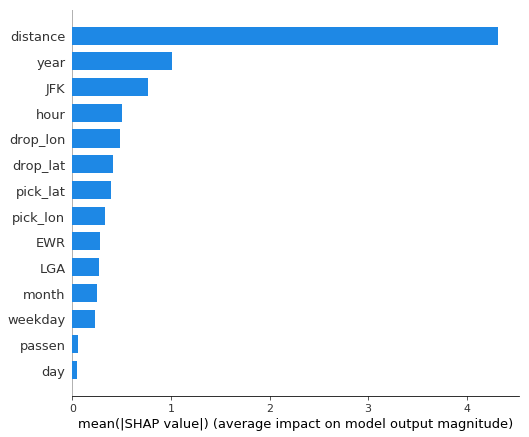

In [46]:
# Importance of each predictor to affect the prediction result
# shap.summary_plot(shap_values, x_train, plot_type="bar")

fig = shap.summary_plot(shap_values, ['distance', 'pick_lon', 'pick_lat', 'drop_lon', 'drop_lat', 'passen', 'year', 'month', 'day', 'hour', 'weekday', 'JFK', 'EWR', 'LGA'], plot_type="bar", show=False)
plt.savefig('bar.png', dpi = 300) 

`distance`: the main effect predictor   
`year`: maybe the price is different in different year   
`jfk_dist`: since the price from/to JFK airport to/from Manhattan is fixed   
`hour`: indicate the possible ruch hour and night hour   
4 position information: differently affect the result.  

`day` and `passenger_count` hardly influence the prediction result

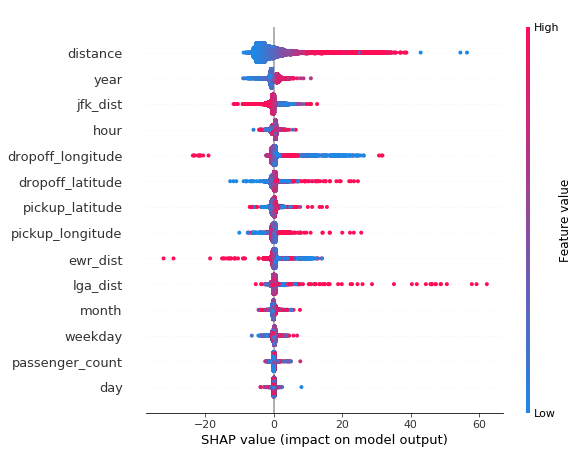

In [47]:
# how different value of each predictor affect the prediction result
fig = shap.summary_plot(shap_values, x_train, show = False)
# fig = shap.summary_plot(shap_values, ['distance', 'pick_lon', 'pick_lat', 'drop_lon', 'drop_lat', 'passen', 'year', 'month', 'day', 'hour', 'weekday', 'JFK', 'EWR', 'LGA'])
plt.savefig('heat.png', dpi = 300) 

Some predictors has obviouly property:   
`distance`: indicates the larger distance correspond to higher taxi fare   
`year`: indicates the taxi fare has been increased through years (change of fare / more crowded on the road)   
`jfk_dist`, `ewr_dist` and `lga_dist`: the lower value (blue) are to/from the airport which is usually a long way so it helps increase the prediction value, and higher value (red) are far from airports which is usually short trip. And since LGA is near the city center, it is less obvious.